In [1]:
import h5py
import pandas as pd
import os
import glob
import pandas as pd
import numpy as np
import tifffile
from tqdm import tqdm
import matplotlib.pyplot as plt
import ast
import re
from datetime import datetime, date
from collections import namedtuple
from itertools import product
from scipy.spatial import distance_matrix

In [2]:
folder = r'/Users/AdamHarris/Documents/Behaviour/cohort10'

mouse_to_maze_dict = {'ah08': 2, 
                        'ah09': 2, 
                        'ah10': 1, 
                        'ly05': 1, 
                        'ly06': 2,
                        'ly07': 1}

maze_1_pixel_pts = np.array([[1022, 974],
                            [981, 136],
                            [158, 169],
                            [172, 1010]])

maze_2_pixel_pts = np.array([[234, 945],
                            [1036, 953],
                            [1020, 158],
                            [248, 169]])


In [3]:


def load_masks_from_directory(mask_dir):
    """
    Load all TIFF binary mask images from a directory. 
    Assumes each mask file is named like 'node_1.tif', 'edge_1-2.tif', etc.
    Returns a dictionary: 
        key = subcomponent name (e.g. 'node_1'), 
        value = 2D numpy array for the binary mask.
    """
    mask_dict = {}
    tiff_files = glob.glob(os.path.join(mask_dir, "*.tif*"))

    for tiff_path in tiff_files:
        filename = os.path.basename(tiff_path)
        # Remove file extension to get subcomponent label
        subcomponent_name, _ = os.path.splitext(filename)
        
        # Read the binary mask as a 2D numpy array
        mask_array = tifffile.imread(tiff_path)
        
        # Ensure boolean type (True/False)
        mask_array = mask_array.astype(bool)
        
        mask_dict[subcomponent_name] = mask_array
    
    return mask_dict


def detect_outliers_by_jump(df, bodypart_names, x_suffix, y_suffix,
                            distance_threshold=None,
                            robust=True, multiplier=3.0):
    """
    Detect outliers based on large frame-to-frame jumps for each bodypart.
    If the distance between consecutive frames exceeds a certain threshold,
    mark those coordinates as NaN.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The data containing body part coordinates (e.g. from a SLEAP CSV).
    bodypart_names : list of str
        List of bodypart labels to process (e.g. ["nose", "tail"]).
    x_suffix : str
        Suffix for x-coordinates (e.g. ".x" or "_x").
    y_suffix : str
        Suffix for y-coordinates.
    distance_threshold : float or None
        If a float, use this fixed threshold (in pixels).
        If None, compute a robust threshold from the distribution of frame-to-frame distances
        using median absolute deviation (MAD) or standard deviation, as specified by 'robust'.
    robust : bool
        If True and distance_threshold is None, use median absolute deviation to set a threshold.
        If False and distance_threshold is None, use mean + multiplier * std.
    multiplier : float
        The multiplier for the robust or standard deviation approach. E.g., 3.0 for 3*MAD or 3*std.
    
    Returns:
    --------
    pd.DataFrame
        A copy of df where outliers have been marked as NaN.
    """
    df_out = df.copy()

    for bp in bodypart_names:
        x_col = f"{bp}{x_suffix}"
        y_col = f"{bp}{y_suffix}"

        if x_col not in df_out.columns or y_col not in df_out.columns:
            continue
        
        x_vals = df_out[x_col].values
        y_vals = df_out[y_col].values

        # Calculate frame-to-frame distances
        # distance[i] = distance between (x[i], y[i]) and (x[i-1], y[i-1])
        dx = np.diff(x_vals)
        dy = np.diff(y_vals)
        dist = np.sqrt(dx**2 + dy**2)
        
        # If no threshold provided, compute from data
        if distance_threshold is None:
            # We'll skip NaNs in dist
            dist_no_nan = dist[~np.isnan(dist)]
            if len(dist_no_nan) == 0:
                # no valid distances, skip
                continue
            if robust:
                # Use median + multiplier * MAD
                median_dist = np.median(dist_no_nan)
                mad = np.median(np.abs(dist_no_nan - median_dist))
                # A common robust scale factor for MAD is 1.4826,
                # but we can keep it simple or adapt as needed.
                if mad == 0:
                    # fallback if all distances are the same
                    distance_threshold = median_dist * multiplier
                else:
                    distance_threshold = median_dist + multiplier * mad
            else:
                # Use mean + multiplier * std
                mean_dist = np.mean(dist_no_nan)
                std_dist = np.std(dist_no_nan)
                distance_threshold = mean_dist + multiplier * std_dist

        # Now we have a distance_threshold, let's mark outliers
        # dist[i] corresponds to jump from frame i to i+1 in x_vals
        # We can mark frame i+1 as NaN if dist[i] is above threshold
        outlier_indices = np.where(dist > distance_threshold)[0] + 1  # shift by 1 for the "destination" frame

        # Mark outliers as NaN
        x_vals[outlier_indices] = np.nan
        y_vals[outlier_indices] = np.nan

        # Save back
        df_out[x_col] = x_vals
        df_out[y_col] = y_vals
    
    return df_out


def interpolate_and_smooth_coordinates(df, bodypart_names, x_suffix, y_suffix,
                                       interpolation_method='linear', 
                                       rolling_window=5):
    """
    For each bodypart.x and bodypart.y column:
      1. Perform NaN interpolation (default 'linear').
      2. Smooth data with a rolling mean of specified window size.
    """
    for bp in bodypart_names:
        x_col = f"{bp}{x_suffix}"
        y_col = f"{bp}{y_suffix}"

        # Skip if columns don't exist
        if x_col not in df.columns or y_col not in df.columns:
            continue

        # Interpolation (fills internal NaNs, can also do 'limit_direction' or 'order' if polynomial, etc.)
        df[x_col] = df[x_col].interpolate(method=interpolation_method, limit_direction='both')
        df[y_col] = df[y_col].interpolate(method=interpolation_method, limit_direction='both')

        # Smoothing with rolling mean
        df[x_col] = df[x_col].rolling(window=rolling_window, min_periods=1, center=True).mean()
        df[y_col] = df[y_col].rolling(window=rolling_window, min_periods=1, center=True).mean()

    return df

def map_body_parts_to_subcomponent(sleap_h5_path, 
                                   mask_dir, 
                                   bodypart_names=['head_back'], 
                                   x_suffix="_x", 
                                   y_suffix="_y",
                                   # Outlier detection parameters
                                   outlier_detection=True,
                                   distance_threshold=None,
                                   robust=True,
                                   multiplier=3.0,
                                   # Interpolation & smoothing parameters
                                   interpolation_method='linear',
                                   rolling_window=5):
    """
        1) Loads SLEAP HDF5 of body part coordinates
        2) Optionally detects & removes large jump outliers
        3) Interpolates + smooths
        4) Loads TIFF binary masks
        5) Maps each body part's (x,y) to a subcomponent
        6) Exports the final mapping in a CSV
        
        Args:
            sleap_h5_path (str): Path to the SLEAP HDF5 file.
            mask_dir (str): Directory containing the binary mask TIFF files.
            output_csv_path (str): Path for saving the output CSV.
            bodypart_names (list): If None, the code will infer from HDF5 dataset names.
            x_suffix (str): Suffix for x coordinates (default "_x").
            y_suffix (str): Suffix for y coordinates (default "_y").
            
            outlier_detection (bool): Whether to do outlier detection by large jumps.
            distance_threshold (float or None): If float, fixed threshold in pixels. If None, auto-calc from data.
            robust (bool): If True and threshold is None, use median+MAD approach; else use mean+std.
            multiplier (float): Multiplier for outlier detection threshold.
            
            interpolation_method (str): Pandas interpolation method (e.g., 'linear', 'time', 'polynomial', etc.).
            rolling_window (int): Window size for rolling average smoothing.
    """
        # 1. Load SLEAP HDF5
    with h5py.File(sleap_h5_path, 'r') as f:
        tracks = f['tracks'][:]
        bodypart_names = bodypart_names or list(f['node_names'][:])


        ##############
        bodypart_names_h5 = [name if isinstance(name, str) else name.decode('utf-8') for name in list(f['node_names'][:])]
        
        if len(bodypart_names) == 1:
            # Find the index in f['node_names'] where the bodypart name appears

            bodypart_ind = np.where(np.array(bodypart_names_h5) == bodypart_names[0])[0][0]
            
      

            data = {bodypart_names[0]: tracks[0, :, bodypart_ind, :]}
            
            data_dict = {}
            data_dict[f"{bodypart_names[0]}{x_suffix}"] = tracks[0, 0, bodypart_ind, :]
            data_dict[f"{bodypart_names[0]}{y_suffix}"] = tracks[0, 1, bodypart_ind, :]
        else:
            data = {name: tracks[0, :, i, :] for i, name in enumerate(bodypart_names)}
            data_dict = {}
            for i, bp in enumerate(bodypart_names):
                data_dict[f"{bp}{x_suffix}"] = tracks[0, 0, i, :]
                data_dict[f"{bp}{y_suffix}"] = tracks[0, 1, i, :]
 
        sleap_df = pd.DataFrame(data_dict)

    # 2. Outlier detection & removal
    if outlier_detection:
        sleap_df = detect_outliers_by_jump(
            sleap_df, 
            bodypart_names, 
            x_suffix, 
            y_suffix,
            distance_threshold=distance_threshold,
            robust=robust, 
            multiplier=multiplier
        )

    # 3. Interpolate & smooth
    sleap_df = interpolate_and_smooth_coordinates(
        sleap_df, 
        bodypart_names, 
        x_suffix, 
        y_suffix,
        interpolation_method=interpolation_method, 
        rolling_window=rolling_window
    )

    # 4. Load binary masks
    masks = load_masks_from_directory(mask_dir)
    # We assume consistent shape
    mask_shape = None
    if len(masks) > 0:
        first_key = next(iter(masks.keys()))
        mask_shape = masks[first_key].shape

    # 5. Map each body part to subcomponent
    output_df = pd.DataFrame(index=sleap_df.index, columns=bodypart_names, dtype=object)

    for i, row_data in sleap_df.iterrows():
        for bp in ['head_back']:
            x_col = f"{bp}{x_suffix}"
            y_col = f"{bp}{y_suffix}"

            if x_col not in sleap_df.columns or y_col not in sleap_df.columns:
                output_df.at[i, bp] = "None"
                continue

            x_coord = row_data[x_col]
            y_coord = row_data[y_col]

            if pd.isna(x_coord) or pd.isna(y_coord):
                output_df.at[i, bp] = "None"
                continue
            
            x_idx = int(round(x_coord))
            y_idx = int(round(y_coord))

            # Check bounds
            if mask_shape is not None:
                h, w = mask_shape
                if x_idx < 0 or x_idx >= w or y_idx < 0 or y_idx >= h:
                    output_df.at[i, bp] = "None"
                    continue

            # Identify which mask is True
            found_subcomponent = False
            for subcomp_name, mask_arr in masks.items():
                if mask_arr[y_idx, x_idx]:
                    output_df.at[i, bp] = subcomp_name
                    found_subcomponent = True
                    break
            if not found_subcomponent:
                output_df.at[i, bp] = "None"

    # 6. Save final output
    return output_df['head_back']


def get_behaviour_txt(Behaviourfile_path, Structure_abstract="ABCD"):
    """
    Retrieves the pycontrol output file for awake sessions and produces a dictionary 
    containing the raw pycontrol data.
    Parameters:
    data_path (str): The base directory path where the data is stored.
    mouse (str): The identifier for the mouse.
    cohort (str): The cohort number or identifier.
    date (str): The date of the session in 'YYYYMMDD' format.
    Behaviour_timestamp (str): The timestamp of the behaviour session.
    Returns:
    dict: A dictionary where keys are event names and values are numpy arrays of event times.
    The function performs the following steps:
    1. Constructs the file path for the behaviour data file.
    2. Reads the file and extracts relevant information.
    3. Parses session information including experiment name, task name, subject ID, and start date.
    4. Extracts state and event IDs, and session data.
    5. Converts subject ID to integer if `int_subject_IDs` is True.
    6. Returns a dictionary with event names as keys and numpy arrays of event times as values.
    Note:
    - The function assumes that the file format and structure are consistent with the expected format.
    """

    

    # print('Importing data file: '+os.path.split(Behaviourfile_path)[1])

    with open(Behaviourfile_path, 'r') as f:
        all_lines = [line.strip() for line in f.readlines() if line.strip()]


    # Extract and store session information.
    file_name = os.path.split(Behaviourfile_path)[1]
    Event = namedtuple('Event', ['time','name'])

    info_lines = [line[2:] for line in all_lines if line[0]=='I']

    experiment_name = next(line for line in info_lines if 'Experiment name' in line).split(' : ')[1]
    task_name       = next(line for line in info_lines if 'Task name'       in line).split(' : ')[1]
    subject_ID_string    = next(line for line in info_lines if 'Subject ID'      in line).split(' : ')[1]
    datetime_string      = next(line for line in info_lines if 'Start date'      in line).split(' : ')[1]



    datetime_ = datetime.strptime(datetime_string, '%Y/%m/%d %H:%M:%S')
    datetime_string = datetime_.strftime('%Y-%m-%d %H:%M:%S')

    # Extract and store session data.

    state_IDs = eval(next(line for line in all_lines if line[0]=='S')[2:])
    event_IDs = eval(next(line for line in all_lines if line[0]=='E')[2:])
    variable_lines = [line[2:] for line in all_lines if line[0]=='V']

    if Structure_abstract not in ['ABCD','AB','ABCDA2','ABCDE','ABCAD']:
        pass
    else:
        structurexx = next(line for line in variable_lines if 'active_poke' in line).split(' active_poke ')[1]
        if 'ot' in structurexx:
            structurex=structurexx[:8]+']'
        else:
            structurex=structurexx

        if Structure_abstract in ['ABCD','AB','ABCDE']:
            structure=np.asarray((structurex[1:-1]).split(',')).astype(int)
        else:
            structure=structurex

        ID2name = {v: k for k, v in {**state_IDs, **event_IDs}.items()}
        data_lines = [line[2:].split(' ') for line in all_lines if line[0]=='D']
        events = [Event(int(dl[0]), ID2name[int(dl[1])]) for dl in data_lines]
        times = {event_name: np.array([ev.time for ev in events if ev.name == event_name])  
                    for event_name in ID2name.values()}
  
    return times, variable_lines

In [4]:
def get_nearest_txt_timestamp(h5_path, mouse):
    # Extract the timestamp from the h5 filename
    h5_filename = os.path.basename(h5_path)
    m = re.search(r'(\d{4}-\d{2}-\d{2}-\d{6})', h5_filename)
    if not m:
        raise ValueError("No valid timestamp found in the h5 filename.")
    h5_timestamp = datetime.strptime(m.group(1), "%Y-%m-%d-%H%M%S")
    
    # Get the directory and list all txt files that include the mouse identifier
    directory = os.path.dirname(h5_path)
    txt_files = [f for f in os.listdir(directory) if f.lower().endswith('.txt') and mouse in f]
    
    nearest_filename = None
    min_timedelta = None
    
    # Try to find a txt file with a timestamp later than or equal to h5 timestamp
    for txt_file in txt_files:
        m_txt = re.search(r'(\d{4}-\d{2}-\d{2}-\d{6})', txt_file)
        if not m_txt:
            continue
        txt_timestamp = datetime.strptime(m_txt.group(1), "%Y-%m-%d-%H%M%S")
        diff = txt_timestamp - h5_timestamp
        if diff.total_seconds() >= 0:
            if min_timedelta is None or diff < min_timedelta:
                min_timedelta = diff
                nearest_filename = txt_file

    # Fallback: if no txt file is later than the h5 file, choose the one with the smallest absolute difference
    if nearest_filename is None:
        for txt_file in txt_files:
            m_txt = re.search(r'(\d{4}-\d{2}-\d{2}-\d{6})', txt_file)
            if not m_txt:
                continue
            txt_timestamp = datetime.strptime(m_txt.group(1), "%Y-%m-%d-%H%M%S")
            diff = abs(txt_timestamp - h5_timestamp)
            if min_timedelta is None or diff < min_timedelta:
                min_timedelta = diff
                nearest_filename = txt_file

    if nearest_filename is not None:
        return os.path.join(directory, nearest_filename)
    else:
        return None

In [5]:
def get_pinstate(h5_path, mouse):
    # Extract the timestamp from the h5 filename.
    h5_filename = os.path.basename(h5_path)
    m = re.search(r'(\d{4}-\d{2}-\d{2}-\d{6})', h5_filename)
    if not m:
        raise ValueError("No valid timestamp found in the h5 filename.")
    h5_timestamp = datetime.strptime(m.group(1), "%Y-%m-%d-%H%M%S")
    
    # Search for CSV files containing 'pinstate' in the filename in the same directory as the h5 file
    directory = os.path.dirname(h5_path)
    csv_files = [f for f in os.listdir(directory) if f.lower().endswith('.csv') and 'pinstate' in f.lower() and mouse in f]
    
    nearest_filename = None
    min_timedelta = None
    
    # First, try to find a csv file with a timestamp later than or equal to h5 timestamp
    for csv_file in csv_files:
        m_csv = re.search(r'(\d{4}-\d{2}-\d{2}-\d{6})', csv_file)
        if not m_csv:
            continue
        csv_timestamp = datetime.strptime(m_csv.group(1), "%Y-%m-%d-%H%M%S")
        diff = csv_timestamp - h5_timestamp
        if diff.total_seconds() >= 0:
            if min_timedelta is None or diff < min_timedelta:
                min_timedelta = diff
                nearest_filename = csv_file

    # Fallback: if no csv is later than the h5 file, choose the one with the smallest absolute difference
    if nearest_filename is None:
        for csv_file in csv_files:
            m_csv = re.search(r'(\d{4}-\d{2}-\d{2}-\d{6})', csv_file)
            if not m_csv:
                continue
            csv_timestamp = datetime.strptime(m_csv.group(1), "%Y-%m-%d-%H%M%S")
            diff = abs(csv_timestamp - h5_timestamp)
            if min_timedelta is None or diff < min_timedelta:
                min_timedelta = diff
                nearest_filename = csv_file

    if nearest_filename is not None:
        return os.path.join(directory, nearest_filename)
    else:
        return None



def get_pinstate_indices(pinstate_series, min_length=3):

    # Convert to a numpy array if necessary.
    arr = pinstate_series.values if hasattr(pinstate_series, 'values') else pinstate_series
    # Create a Boolean mask for high values.
    high_mask = (arr == max(arr))
    indices = []
    for i in range(len(arr)):
        # Check if this is a transition: current is high and either it's the very first element
        # or the previous state was low.
        if high_mask[i] and (i == 0 or not high_mask[i-1]):
            # Ensure that there are enough data points and that the next (min_length-1) values are high.
            if i + min_length - 1 < len(arr) and np.all(high_mask[i:i+min_length]):
                indices.append(i)
    return np.array(indices)

def extract_task(variables, index=0):
    bracket_part = re.search(r'\[.*\]', variables[index]).group(0)
    return ast.literal_eval(bracket_part)

def get_sorted_h5_files(mouse, folder):
    return sorted(
        [i for i in os.listdir(folder) if mouse in i and '.h5' in i],
        key=lambda fname: datetime.strptime(
            re.search(r'(\d{4}-\d{2}-\d{2}-\d{6})', fname).group(1),
            "%Y-%m-%d-%H%M%S"
        )
    )

In [6]:
def build_mapping_dict():
    """
    Builds and returns a dictionary that maps node labels (node_1 through node_9)
    to integers 1-9, and edge labels (edge_1-2, edge_1-4, etc.) to integers 10-21.
    
    Feel free to modify or expand the edges list if needed.
    """
    # 1) Node labels: "node_1" -> 1, "node_2" -> 2, ..., "node_9" -> 9
    mapping_dict = {}
    for i in range(1, 10):
        mapping_dict[f"node_{i}"] = i

    # 2) Define the list of edges you have in your maze
    #    For example, let's pretend we have 12 distinct edges total
    #    so that they map from 10 to 21 (12 edges). Adjust as needed.


    edges = [
        "1-2",  # corresponds to "edge_1-2"
        "2-3",
        "1-4",
        "2-5",
        "3-6",
        "4-5",
        "5-6",
        "4-7",
        "5-8",
        "6-9",
        "7-8",
        "8-9",
    ]

    # 3) Starting from integer 10 for edges. We create keys of the form "edge_1-2"
    start_value = 10
    for idx, edge in enumerate(edges, start=start_value):
        mapping_dict[f"edge_{edge}"] = idx

    return mapping_dict


def convert_label_to_int(label, mapping):
    """
    Given a label (e.g., 'node_4' or 'edge_1-2') and a mapping dictionary,
    returns the corresponding integer code.
    """
    if pd.isna(label) or label == 'nan':
        return np.nan
    # Otherwise, look up in the mapping dictionary
    if label not in mapping:
        raise ValueError(f"Label '{label}' not found in mapping dictionary.")
    return mapping[label]

def get_mindistance_mat():
    
    x=(0,1,2)
    Task_grid=np.asarray(list(product(x, x)))

    mapping_pyth={2:2,5:3,8:4}

    distance_mat_raw=distance_matrix(Task_grid, Task_grid)
    len_matrix=len(distance_mat_raw)
    distance_mat=np.zeros((len_matrix,len_matrix))
    for ii in range(len_matrix):
        for jj in range(len_matrix):
            if (distance_mat_raw[ii,jj]).is_integer()==False:
                hyp=int((distance_mat_raw[ii,jj])**2)
                distance_mat[ii,jj]=mapping_pyth[hyp]
            else:
                distance_mat[ii,jj]=distance_mat_raw[ii,jj]
    mindistance_mat=distance_mat.astype(int)
    
    return mindistance_mat

def make_trial_times_array(times_dic, target_binning=1000/60, Structure_abstract='ABCD'):



    if Structure_abstract == 'ABCD':
        states = ['A_on', 'B_on', 'C_on', 'D_on']
    elif Structure_abstract == 'ABCDE':
        states = ['A_on', 'B_on', 'C_on', 'D_on', 'E_on']
    elif Structure_abstract == 'AB':
        states = ['A_on', 'B_on']
    elif Structure_abstract == 'ABCAD':
        states = ['A_on', 'B_on', 'C_on', 'A2_on', 'D_on']
    else:
        raise ValueError(f"Unknown Structure_abstract: {Structure_abstract}")


    for state in states:
        if state not in times_dic:
            raise ValueError(f"State {state} not found in times_dic")

    num_trials = min([len(times_dic[state]) for state in states])
    
    trial_times = np.zeros((num_trials - 1, len(states) + 1), dtype=int)
    for i in range(num_trials - 1):
        # current trial: all state times in order
        trial_times[i, :-1] = [times_dic[state][i] for state in states]
        # periodic: the next trial's first state's time becomes the last element
        trial_times[i, -1] = times_dic[states[0]][i + 1]

    conversion_factor = 1000/60
    return (trial_times/conversion_factor).astype(int)

    

In [7]:
def get_mouse_locations(trial_times_array, ROIs_int):
    """
    Given a trial times array and a list of ROIs_int, returns an array of the same structure
    but where the entries are the mouse's location at each of the time bins.
    
    Parameters:
    -----------
    trial_times_array : np.ndarray
        Array of trial times.
    ROIs_int : list
        List of mouse locations (ROIs) as integers.
    
    Returns:
    --------
    np.ndarray
        Array of the same structure as trial_times_array but with mouse locations.
    """
    n_trials, n_states = trial_times_array.shape
    mouse_locations = np.zeros_like(trial_times_array, dtype=int)
    
    for i in range(n_trials):
        for j in range(n_states):
            time_bin = int(trial_times_array[i, j])
            if time_bin < len(ROIs_int):
                if np.isnan(ROIs_int[time_bin]):
                    mouse_locations[i, j] = 999
                else:
                    mouse_locations[i, j] = ROIs_int[time_bin]
            else:
                mouse_locations[i, j] = np.nan  # Handle out-of-bounds case
    
    return mouse_locations


In [8]:
def score_trials(trial_times, ROIs_int, task, mindistance_mat):
    """
    takes trial times array structured as follows:
      [[a1, b1, c1, d1, a2], 
       [a2, b2, c2, d2, a3],
       ...
       [an-1, bn-1, cn-1, dn-1, dn]]
    a list called task that contains the locations in int format of each of the goals,
    and mindistance_mat that specifies the shortest number of steps between two locations.
    
    Note: Only node locations (1-9) count; consecutive duplicates are removed.
    Returns:
      shortest_paths_array - a 2D array (n x 4) where each entry is 1 if the mouse took the shortest path,
      session_performance - the fraction of entries in shortest_paths_array that are 1.
    """
    n_trials = trial_times.shape[0]
    shortest_paths_array = np.zeros((n_trials, 4))

    for i in range(n_trials):
        for j in range(4):
            start_time = trial_times[i, j]
            end_time = trial_times[i, j + 1]
            start_location = task[j]
            end_location = task[(j + 1) % 4]

            # Get the ROI indices for the current trial segment (as a list)
            trial_segment = ROIs_int[int(start_time):int(end_time)]
            
            # Convert to numpy array to filter node locations (1-9)
            trial_segment_arr = np.array(trial_segment)
            node_mask = trial_segment_arr <= 9
            filtered_nodes = trial_segment_arr[node_mask]
            
            # Remove consecutive duplicates by converting to a pandas Series
            node_series = pd.Series(filtered_nodes)
            node_unique = node_series[node_series.shift() != node_series].reset_index(drop=True)

            if len(node_unique) > 1:
                # Calculate the number of steps taken based on consecutive pairs
                steps_taken = sum(mindistance_mat[int(node_unique.iloc[k]) - 1, int(node_unique.iloc[k + 1]) - 1] 
                                  for k in range(len(node_unique) - 1))
            else:
                steps_taken = np.inf

            # Get the shortest path distance from start to end
            shortest_path_distance = mindistance_mat[int(start_location) - 1, int(end_location) - 1]

            # Mouse took the shortest path if steps match shortest_path_distance
            shortest_paths_array[i, j] = 1 if steps_taken == shortest_path_distance else 0

    session_performance = np.mean(shortest_paths_array)
    return shortest_paths_array, session_performance


In [12]:
import re

sampling_rate_conversion = 1000/60

mindistance_mat = get_mindistance_mat()
mapping_dict = build_mapping_dict()

scores_dic = {}

for mouse in mouse_to_maze_dict.keys():
    maze_id = mouse_to_maze_dict[mouse]
    masks_directory = f"/Users/AdamHarris/Desktop/cohort10_masks/maze{maze_id}"
    sleap_h5_paths = get_sorted_h5_files(mouse, folder)
    sleap_h5_paths = [os.path.join(folder, i) for i in sleap_h5_paths if '05-05' in i]
    scores_dic[mouse] = {}

    for i in sleap_h5_paths:

        

        ROIs = map_body_parts_to_subcomponent(i, masks_directory)


        # with h5py.File(i, 'r') as f:
        #     # Convert node names from bytes if needed
        #     bodypart_names = [name.decode('utf8') if isinstance(name, bytes) else name 
        #                       for name in f['node_names'][:]]
        #     tracks = f['tracks'][:]  # shape: (1, 2, num_bodyparts, num_frames)
        # bp = 'head_back'
        # idx = bodypart_names.index(bp)
        # x = tracks[0, 0, idx, :]
        # y = tracks[0, 1, idx, :]

        # # Plot points colored by ROI
        # plt.figure(figsize=(8,6))
        # roi_labels, roi_uniques = pd.factorize(ROIs)
        # colors = plt.cm.jet(np.linspace(0, 1, len(roi_uniques)))
        # for j, roi in enumerate(roi_uniques):
        #     plt.scatter(x[roi_labels==j], y[roi_labels==j], s=1, color=colors[j], label=roi)
        # plt.xlabel("X")
        # plt.ylabel("Y")
        # plt.legend(fontsize=6)
        # plt.title("SLEAP head_back: x and y colored by ROI")
        # plt.show()


        behaviour_txt = get_nearest_txt_timestamp(i, mouse)
        behaviour_timestamps, variables = get_behaviour_txt(behaviour_txt)
        task = extract_task(variables)
        

        
        pinstate_csv = get_pinstate(i, mouse)
        pinstate = pd.read_csv(pinstate_csv)
        print(len(pinstate))
        print(len(ROIs))
        pinstate = pinstate.squeeze()
        sync_indices = np.where(pinstate > np.median(pinstate))[0]
        sync_indices = sync_indices[np.diff(np.concatenate(([0], sync_indices))) > 1]        
        print(len(sync_indices), len(behaviour_timestamps['rsync']))

        # if len(sync_indices) == 0:
        #     # Extract the timestamp from the current pinstate filename using a regex
        #     current_basename = os.path.basename(pinstate_csv)
        #     current_match = re.search(r"(\d+(?:\.\d+)?)", current_basename)
        #     if current_match:
        #         current_timestamp = float(current_match.group(1))
        #         parent_dir = os.path.dirname(pinstate_csv)
        #         alternative_file = None
        #         # Scan for alternative pinstate CSV files in the same directory
        #         for fname in os.listdir(parent_dir):
        #             if fname.endswith('.csv') and mouse not in fname:
        #                 alt_match = re.search(r"(\d+(?:\.\d+)?)", fname)
        #                 if alt_match:
        #                     alt_timestamp = float(alt_match.group(1))
        #                     # Check if the alternative timestamp is within 1 or 2 seconds of the current one
        #                     time_diff = abs(alt_timestamp - current_timestamp)
        #                     if 1 <= time_diff <= 2:
        #                         alternative_file = os.path.join(parent_dir, fname)
        #                         break
        #         if alternative_file is not None:
        #             pinstate_csv = alternative_file
        #             pinstate = pd.read_csv(pinstate_csv)
        #             pinstate = pinstate.squeeze()
        #             sync_indices = np.where(pinstate > np.median(pinstate))[0]
        #             sync_indices = sync_indices[np.diff(np.concatenate(([0], sync_indices))) > 1]
        
        if len(sync_indices) == len(behaviour_timestamps['rsync']):

            
            first_pinstate = sync_indices[0]
            trial_times_array = make_trial_times_array(behaviour_timestamps,
                                                        target_binning=1000/60, 
                                                        Structure_abstract="ABCD")
            if len(trial_times_array)<1:
                print('skipping, no trials')
                continue

            ROIs_single_bp = ROIs[first_pinstate:]
            ROIs_int = [mapping_dict[i] if i in mapping_dict else np.nan for i in ROIs_single_bp]
            # Replace np.nan values in ROIs_int with the last valid integer
            
            first_valid_int = next((val for val in ROIs_int if not np.isnan(val)), None)
            for idx in range(len(ROIs_int)):
                if np.isnan(ROIs_int[idx]):
                    ROIs_int[idx] = ROIs_int[idx - 1] if idx > 0 else first_valid_int
            
            trial_locs = get_mouse_locations(trial_times_array, ROIs_int)
            shortest_paths_array, session_performance = score_trials(trial_times_array,
                                                                    ROIs_int,
                                                                    task,
                                                                    mindistance_mat) 

            # scores_dic[mouse][task] = {}
            # scores_dic[mouse][task][]['scores'] = shortest_paths_array
            # scores_dic[mouse][task]['session_performance']session_performance
            print(os.path.split(i)[1])
            print(os.path.split(behaviour_txt)[1])
            print(os.path.split(pinstate_csv)[1])
            print(task)
            print(shortest_paths_array)
            print(trial_locs)
            print(f"{mouse} performance = {session_performance}")
            print("_______________________")
        
        else:
            print(os.path.split(i)[1])
            print(os.path.split(behaviour_txt)[1])
            print(os.path.split(pinstate_csv)[1])
            print(task)
            print("ruh roh, pinstate and rsync dont match. Skipping")
            print("_______________________")


73368
73369
231 231
labels.v031.000_ah08_2025-05-05-113534.analysis.h5
ah08-2025-05-05-113539.txt
ah08_pinstate_2025-05-05-113534.csv
[4, 9, 7, 1]
[[0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [1. 1. 1. 0.]
 [1. 1. 1. 0.]
 [1. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [1. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [1. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 1.]
 [1. 1. 1. 0.]
 [0. 1. 1. 0.]
 [1. 1. 0. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 0.]
 [0. 1. 1. 0.]]
[[4 9 7 1 4]
 [4 9 7 1 4]
 [4 9 7 1 4]
 [4 9 7 1 4]
 [4 9 7 1 4]
 [4 9 7 1 4]
 [4 9 7 1 4]
 [4 9 7 1 4]
 [4 9 7 1 4]
 [4 9 7 1 4]
 [4 9 7 1 4]
 [4 9 7 1 4]
 [4 9 7 1 4]
 [4 9 7 1 4]
 [4 9 7 1 4]
 [4 9 7 1 4]
 [4 9 7 1 4]
 [4 9 7 1 4]
 [4 9 7 1 4]
 [4 9 7 1 4]
 [4 9 7 1 4]
 [4 9 7 1 4]
 [4 9 7 1 4]]
ah08 performance = 0.6413043478260869
_______________________
74316
74317
236 236
labels.v031.001_ah08_2025-05-05-124610.analysis.h5
ah08-2025-05-05-124631.txt
ah08_pinstate_2025-05-05-124610.csv
[4, 9, 7, 1

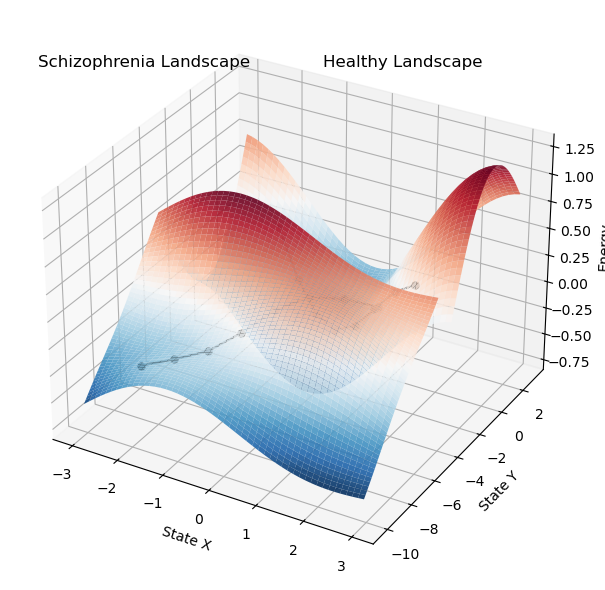

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def schizophrenia_energy(x, y):
    """
    Example function to simulate a 'shallower' energy landscape.
    Modify to taste.
    """
    # We create some undulating landscape with lower-amplitude variations.
    return 0.2 * np.sin(x) * np.cos(y) + 0.3 * np.cos(0.5 * x) + 0.2 * y

def healthy_energy(x, y):
    """
    Example function to simulate a 'deeper' or more structured energy landscape.
    Modify to taste.
    """
    # A similar wavy function but scaled to have deeper minima.
    return 0.8 * np.sin(0.5 * x) * np.cos(0.5 * y) - 0.5 * np.cos(x) + 0.1 * y

def main():
    # Create a figure and a 3D axis
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Define the ranges for X and Y
    x_min, x_max = -3, 3
    y_min, y_max = -3, 3
    resolution = 50

    # Generate the base mesh
    x = np.linspace(x_min, x_max, resolution)
    y = np.linspace(y_min, y_max, resolution)
    X, Y = np.meshgrid(x, y)

    # -----------------------------------------------
    # 1) Schizophrenia landscape
    # -----------------------------------------------
    Z_sch = schizophrenia_energy(X, Y)

    # We'll plot this surface shifted in the negative Y-direction 
    # so it doesn't overlap with the healthy surface visually.
    # (Alternatively, you could shift in X if you prefer.)
    y_offset = - (y_max - y_min) * 1.2  # Shift by 1.2 times the Y range
    Y_sch_offset = Y + y_offset

    # Plot the schizophrenia surface
    surf_sch = ax.plot_surface(X, Y_sch_offset, Z_sch, 
                               cmap='RdBu_r', 
                               linewidth=0, 
                               antialiased=True,
                               alpha=0.9)

    # -----------------------------------------------
    # 2) Healthy landscape
    # -----------------------------------------------
    Z_hlt = healthy_energy(X, Y)

    # No offset for healthy (or a different offset if you like)
    surf_hlt = ax.plot_surface(X, Y, Z_hlt, 
                               cmap='RdBu_r', 
                               linewidth=0, 
                               antialiased=True,
                               alpha=0.9)

    # -----------------------------------------------
    # 3) Illustrative 'ball' / trajectory
    # -----------------------------------------------
    # Let's define a simple path across the schizophrenia landscape
    # and a path across the healthy landscape, marking them with scatter.
    # These paths are purely for illustration; in practice, you'd set them
    # to follow the gradient or some empirical trajectory.

    # For schizophrenia side:
    sch_traj_x = np.linspace(-2, 2, 8)
    sch_traj_y = np.linspace(-2, 2, 8)
    sch_traj_z = schizophrenia_energy(sch_traj_x, sch_traj_y)
    # Apply the same offset in Y
    sch_traj_y_offset = sch_traj_y + y_offset

    ax.plot(sch_traj_x, sch_traj_y_offset, sch_traj_z, 
            color='black', linestyle='-', marker='o', markersize=5)

    # For healthy side:
    hlt_traj_x = np.linspace(-2, 2, 8)
    hlt_traj_y = np.linspace(2, -2, 8)
    hlt_traj_z = healthy_energy(hlt_traj_x, hlt_traj_y)

    ax.plot(hlt_traj_x, hlt_traj_y, hlt_traj_z, 
            color='black', linestyle='-', marker='o', markersize=5)

    # -----------------------------------------------
    # 4) Aesthetics
    # -----------------------------------------------
    # We can add text labels near each surface to identify them
    ax.text2D(0.05, 0.9, "Schizophrenia Landscape", transform=ax.transAxes, fontsize=12)
    ax.text2D(0.55, 0.9, "Healthy Landscape", transform=ax.transAxes, fontsize=12)

    # Set the axis labels
    ax.set_xlabel("State X")
    ax.set_ylabel("State Y")
    ax.set_zlabel("Energy")

    # Adjust view angle for a nice perspective
    ax.view_init(elev=30, azim=-60)

    # Optionally add color bar for the last surface plotted
    # (But note that it will not simultaneously represent both surfaces 
    # unless they share the same colormap range. For demonstration, we’ll skip.)
    # fig.colorbar(surf_hlt, shrink=0.5, aspect=10)

    # Set tight layout and show
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


# To do 

- Checks that the nearest files isnt crazy far away in time (would be an issue for matching across sessions if files are missing)

- integrate usual preprocessing code for coordinates so discrete locations don't have to be recomputed

- save out scores arrays in dataframe or dict for each session so that we can plot performance over trials for each task rather than for individual sessions